## Setting Up Your Python Environment

Train to differentiate thyroid cancer (based on the tutorials)
1. https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
2. https://christianjmills.com/posts/pytorch-train-image-classifier-timm-hf-tutorial/#recommended-tutorials
3. https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452

## Importing the Required Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils datasets timm torchtnt torcheval

In [3]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from os import listdir
from shutil import copyfile

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import tqdm for progress bar
from tqdm.auto import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler


import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
from AI4Thyroid.windows_utils_hf import CustomTrivialAugmentWide
from AI4Thyroid.windows_utils_hf import ResizePad

from timm.data.auto_augment import rand_augment_transform
from torchvision.io import read_image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import cv2
from cv2 import imread, imwrite, resize, imshow

## Setting Up the Project

### Setting a Random Number Seed

In [4]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [5]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cpu', torch.float32)

# Load data

In [6]:
summary_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/Tanzania-Data/TAN_THYROID_summary.csv', index_col=0)
clf_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/Tanzania-Data/TAN_THYROID_classification_summary.csv', index_col=0)

In [7]:
summary_df.head()

,Scan ID,Cytology no.,Diagnosis/Bethesda system,Bethesda actual,Histopathology,Present,Present (Manual)
0,TAN001,C-11-22,Malignant,6,Anaplastic carcinoma,1,exist
1,TAN002,C-20-22,Benign nodule,2,Simple Nodular Goitre,1,exist
2,TAN003,C-53-23,Benign nodule,2,Simple Nodular Goitre,1,exist
3,TAN004,C-36-23,Benign nodule,2,Simple Nodular Goitre,1,exist
4,TAN005,C-373-20,Benign nodule,2,Simple Nodular Goitre,1,exist


In [8]:
clf_df.head()

,img_path,label,dataset
0,/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/Tanzania-Data/TAN001/IMG_20220623_141001.jpg,6,test
1,/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/Tanzania-Data/TAN001/IMG_20220623_141241.jpg,6,train
2,/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/Tanzania-Data/TAN001/IMG_20220623_140029.jpg,6,train
3,/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/Tanzania-Data/TAN001/IMG_20220623_141314.jpg,6,train
4,/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/Tanzania-Data/TAN001/IMG_20220623_134910.jpg,6,test


In [9]:
clf_df.groupby('dataset')['label'].value_counts().to_frame('count').reset_index().pivot('dataset', 'label','count')

<ipython-input-9-2489d7f82a84>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  clf_df.groupby('dataset')['label'].value_counts().to_frame('count').reset_index().pivot('dataset', 'label','count')


label,1,2,3,4,5,6
dataset,,,,,,
test,1,200,4,17,2,32
train,7,554,12,84,17,109
val,3,195,2,36,5,27


In [10]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [11]:
batch_size=16

In [12]:
# prompt: i need pytorch dataset that read from dataframe

class ThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, class_list, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_list = class_list

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        # label = self.dataframe['label'][idx]
        label = self.class_list.index(self.dataframe.loc[idx, 'label'])
        image = Image.open(image_path)
        image = Image.fromarray(create_mask(np.array(image)))
        if self.transform:
            image = self.transform(image)
        return image, label


In [13]:

train_df = clf_df[clf_df['dataset']=='train'].reset_index(drop=True)
val_df = clf_df[clf_df['dataset']=='val'].reset_index(drop=True)
test_df = clf_df[clf_df['dataset']=='test'].reset_index(drop=True)

In [14]:
# train_folder = 'C:/Users/ngoth/OneDrive - flsouthern.edu/Research/AI4Thyroid/Tanzania-Data-Train/'
# test_folder = 'C:/Users/ngoth/OneDrive - flsouthern.edu/Research/AI4Thyroid/Tanzania-Data-Test/'

In [15]:
# train_df = pd.read_csv(train_folder + '/train_image_path.csv')
# train_df.head()

In [16]:
# valid_df = pd.read_csv(test_folder + '/test_image_path.csv')
# valid_df.head()

### Loading the ResNet18-D Model

In [17]:
pd.DataFrame(timm.list_models('efficientnet*', pretrained=True))

,0
0,efficientnet_b0.ra_in1k
1,efficientnet_b1.ft_in1k
2,efficientnet_b1_pruned.in1k
3,efficientnet_b2.ra_in1k
4,efficientnet_b2_pruned.in1k
5,efficientnet_b3.ra2_in1k
6,efficientnet_b3_pruned.in1k
7,efficientnet_b4.ra2_in1k
8,efficientnet_b5.sw_in12k
9,efficientnet_b5.sw_in12k_ft_in1k


In [18]:
# Import the resnet module
from timm.models import efficientnet

# Define the ResNet model variant to use
#resnet_model = 'resnet18d'
efficientnet_model = 'efficientnetv2_rw_t'
# Get the default configuration of the chosen model
model_cfg = efficientnet.default_cfgs[efficientnet_model].default.to_dict()

# Show the default configuration values
pd.DataFrame.from_dict(model_cfg, orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnetv2_t_agc-3620981a.pth
hf_hub_id,timm/
custom_load,False
input_size,"(3, 224, 224)"
test_input_size,"(3, 288, 288)"
fixed_input_size,False
interpolation,bicubic
crop_pct,1.0
crop_mode,center
mean,"(0.485, 0.456, 0.406)"


In [19]:
# Create a pretrained ResNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
class_names = sorted(summary_df['Bethesda actual'].unique())
print('Class names:', class_names)
efficientnetv2 = timm.create_model(efficientnet_model, pretrained=True, num_classes=len(class_names))#, global_pool='catavgmax')

# Set the device and data type for the model
efficientnetv2 = efficientnetv2.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
efficientnetv2.device = device
efficientnetv2.name = efficientnet_model

Class names: [1, 2, 3, 4, 5, 6]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Selecting the Model

In [20]:
model = efficientnetv2

In [21]:
model.global_pool

SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

In [22]:
vars(model).keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'num_classes', 'num_features', 'drop_rate', 'grad_checkpointing', 'feature_info', 'pretrained_cfg', 'default_cfg', 'device', 'name'])

In [23]:
model.get_classifier()

Linear(in_features=1024, out_features=6, bias=True)

In [24]:
num_in_features = model.get_classifier().in_features
num_in_features

1024

### Summarizing the Model

In [25]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,EfficientNet,12.6 M,12.6 M,51.0 M,2.5 G,30.8 G,"[1, 3, 256, 256]","[1, 6]"
1,Conv2d,648,648,2.6 K,10.6 M,10.6 M,"[1, 3, 256, 256]","[1, 24, 128, 128]"
8,Conv2d,5.2 K,5.2 K,20.7 K,84.9 M,169 M,"[1, 24, 128, 128]","[1, 24, 128, 128]"
14,Conv2d,5.2 K,5.2 K,20.7 K,84.9 M,169 M,"[1, 24, 128, 128]","[1, 24, 128, 128]"
21,Conv2d,20.7 K,20.7 K,82.9 K,84.9 M,169 M,"[1, 24, 128, 128]","[1, 96, 64, 64]"
26,Conv2d,3.8 K,3.8 K,15.4 K,15.7 M,31.5 M,"[1, 96, 64, 64]","[1, 40, 64, 64]"
32,Conv2d,57.6 K,57.6 K,230 K,235 M,471 M,"[1, 40, 64, 64]","[1, 160, 64, 64]"
37,Conv2d,6.4 K,6.4 K,25.6 K,26.2 M,52.4 M,"[1, 160, 64, 64]","[1, 40, 64, 64]"
43,Conv2d,57.6 K,57.6 K,230 K,235 M,471 M,"[1, 40, 64, 64]","[1, 160, 64, 64]"
48,Conv2d,6.4 K,6.4 K,25.6 K,26.2 M,52.4 M,"[1, 160, 64, 64]","[1, 40, 64, 64]"


### Retrieving Normalization Statistics

In [26]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# Inspect a sample image

/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/Tanzania-Data/TAN065/IMG_230116131142180.jpg


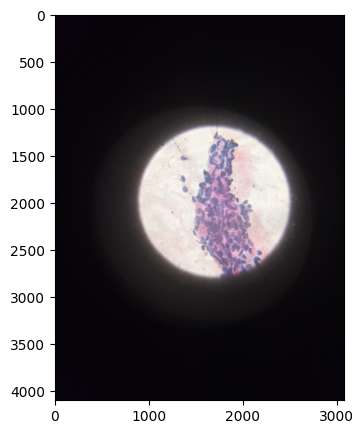

In [27]:
# Select a random item from the dataset
item_path = random.choice(train_df['img_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

In [28]:
def create_mask(img):
    '''Input: image
    Output: cropped image'''
    #convert to grayscale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Gaussian blur
    img_blur = cv2.GaussianBlur(img_gray,(15,15),10)
    #thresholding using auto threshold Triangle
    threshold, thresholded_image = cv2.threshold(img_blur,50,255,cv2.THRESH_BINARY)
    #fill holes by closing operation (dilation followed by erosion)
    #closed = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, np.ones((20,20),np.uint8))
    #remove noise by erosion
    #mask1 = closed #cv2.erode(closed, np.ones((30,30),np.uint8),iterations = 1)
    """
    #remove noise by opening (erosion followed by dilation)
    opening = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, np.ones((30,30),np.uint8))
    #fill holes by dilation
    mask= cv2.dilate(opening, np.ones((30,30),np.uint8),iterations = 1)
    """
    #create a rectangular mask
    #h, w, _ = img.shape
    #rec_mask = np.zeros((h,w), np.uint8)
    #rec_mask[ceil(h/4):ceil(3*h/4),ceil(w/4):ceil(3*w/4)] = 255
    # combine mask1 and rectangular mask to create final mask2
    #mask2 = cv2.bitwise_and(mask1,rec_mask)
    ### finding contours, can use connectedcomponents aswell
    contours, hierarchy = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the index of the largest contour
    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    cnt = contours[max_index]
    ### converting to bounding boxes from polygon
    bounding=cv2.boundingRect(cnt)

    #print(contours)
    ### drawing rectangle for each contour for visualising

    # plot image and mask2
    #plt.subplot(1,3,1)
    #plt.imshow(img)
    #plt.subplot(1,3,2)
    #plt.imshow(cv2.cvtColor(thresholded_image, cv2.COLOR_BGR2RGB))
    #plt.subplot(1,3,3)
    #for cnt in contours:
    x,y,w,h = bounding
        #plt.imshow(cv2.rectangle(thresholded_image,(x,y),(x+w,y+h),(0,255,0),3))
    #plt.show()
    #print('Image shape: ', img.shape)
    #print(x, y, w, h)
    return img[y:y+h, x:x+w]  #ATTENTION to y and x!!!

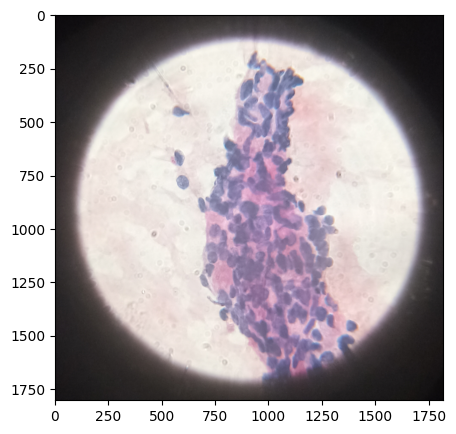

In [29]:
sample_img = Image.fromarray(create_mask(np.array(sample_img)))
#print(sample_img_cropped)
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

### Image Resizing and Padding and test on the sample image

Source image: (1816, 1803)
Cropped image: (1816, 903)
Cropped tensor: torch.Size([1, 3, 903, 1816])
Padded tensor: torch.Size([1, 3, 288, 288])


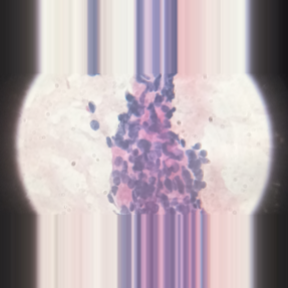

In [30]:
### Image Resizing and Padding
#### Resize Pad Transform

#### Set training image size
train_sz = (288,288)
print(f"Source image: {sample_img.size}")

# Crop the source image
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])
print(f"Cropped image: {cropped_img.size}")

# Create a `ResizePad` object
resize_pad = ResizePad(max_sz=max(train_sz))

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(cropped_img)[None]
print(f"Cropped tensor: {img_tensor.shape}")

# Resize and pad the tensor
resized_tensor = resize_pad(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Display the updated image
tensor_to_pil(resized_tensor)

### Image transformations for training and validation datasets

In [31]:
train_transform = rand_augment_transform(config_str='rand-m9-mstd0.5', hparams={'img_mean': (124, 116, 104)})
train_transform

RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Posterize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Solarize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Color, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Contrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Brightness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Sharpness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=9, mstd=0.5))

In [32]:
# # Note: Resize and Padding on both training and valid. Data augmentation is performed only on the training dataset
train_tfms = transforms.Compose([
    ResizePad(max_sz=max(train_sz)),
    train_transform,
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
])

valid_tfms = transforms.Compose([
    ResizePad(max_sz=max(train_sz)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
])

# Create CustomDataset

In [33]:
bs = 16

In [34]:
print(class_names)

[1, 2, 3, 4, 5, 6]


# Create Dataloader

In [35]:
# #create dataset using csv https://rumn.medium.com/how-to-create-a-custom-pytorch-dataset-with-a-csv-file-e64b89bc2dcc
# class CustomDataSet(Dataset):
#     def __init__(self, data_frame, class_list, transform=None):
#         self.df = data_frame
#         self.transform = transform
#         self.class_list = class_list

#     def __len__(self):
#         return self.df.shape[0]

#     def __getitem__(self, index):
#         image = Image.open(self.df.image_path[index])
#         image = Image.fromarray(create_mask(np.array(image)))
#         label = self.class_list.index(self.df.loc[index, 'Bethesda actual'])

#         if self.transform:
#             image = self.transform(image)
#         return image, label

In [36]:
# train_data_object = CustomDataSet(train_df, class_names, train_tfms)
# print(len(train_data_object))

In [37]:
# valid_data_object = CustomDataSet(valid_df, class_names, valid_tfms)
# print(len(valid_data_object))

In [38]:
# # count number of samples for each class
# class_counts = train_df['Bethesda actual'].value_counts().sort_index()
# class_counts

In [39]:
# class_counts = train_df['Bethesda actual'].value_counts().sort_index()
# class_counts

In [40]:
# class_weights = 1./class_counts
# class_weights

In [41]:
# sample_weights = [1/class_counts[i] for i in train_df['Bethesda actual'].values]; sample_weights

In [42]:
# sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_data_object), replacement=True)

In [43]:
# train_dataloader = torch.utils.data.DataLoader(train_data_object, batch_size=bs, sampler=sampler) #shuffle=True)
# valid_dataloader = torch.utils.data.DataLoader(valid_data_object, batch_size=bs, shuffle=True)

In [44]:
class_names

[1, 2, 3, 4, 5, 6]

In [45]:
trainset = ThyroidDataset(train_df, class_names, transform=train_tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [46]:
valset = ThyroidDataset(val_df, class_names, transform=valid_tfms)
valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

In [47]:
testset = ThyroidDataset(test_df, class_names, transform=valid_tfms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

In [48]:
print(len(trainloader))

49


# Let’s plot a batch of image from our custom dataset

In [49]:
# train_features, train_labels = next(iter(trainloader))

Feature batch shape: torch.Size([16, 3, 288, 288])
Labels batch shape: torch.Size([16])


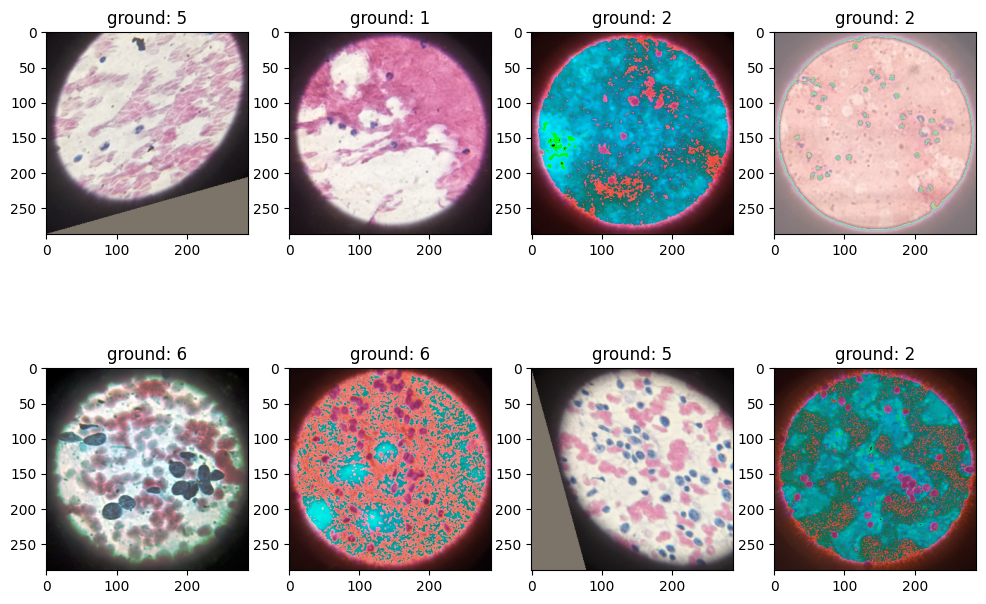

In [50]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = class_names[train_labels[indx]]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1

#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Fine-tuning the Model

### Define the Training Loop

In [51]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, is_training):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()

    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    # Iterate over data batches
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device (e.g., GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Enables gradient calculation if 'is_training' is True
        with torch.set_grad_enabled(is_training):
            # Automatic Mixed Precision (AMP) context manager for improved performance
            with autocast(device):
                outputs = model(inputs) # Forward pass
                loss = torch.nn.functional.cross_entropy(outputs, targets)#, weight=torch.FloatTensor(class_weights.values).to(device)) # Compute loss

        # Update the performance metric
        metric.update(outputs.detach().cpu(), targets.detach().cpu())

        # If in training mode
        if is_training:
            if scaler is not None: # If using AMP
                # Scale the loss and backward propagation
                scaler.scale(loss).backward()
                scaler.step(optimizer) # Make an optimizer step
                scaler.update() # Update the scaler
            else:
                loss.backward() # Backward propagation
                optimizer.step() # Make an optimizer step

            optimizer.zero_grad() # Clear the gradients
            lr_scheduler.step() # Update learning rate

        loss_item = loss.item()
        epoch_loss += loss_item
        # Update progress bar
        progress_bar.set_postfix(accuracy=metric.compute().item(),
                                 loss=loss_item,
                                 avg_loss=epoch_loss/(batch_id+1),
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if math.isnan(loss_item) or math.isinf(loss_item):
            print(f"Loss is NaN or infinite at epoch {epoch}, batch {batch_id}. Stopping training.")
            break

    progress_bar.close()
    return epoch_loss / (batch_id + 1)

In [52]:
# Main training loop
def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, use_grad_scaler, checkpoint_path):
    # Initialize GradScaler for Automatic Mixed Precision (AMP) if 'use_grad_scaler' is True
    scaler = GradScaler() if use_grad_scaler else None
    best_loss = float('inf')
    train_loss_hist = []
    valid_loss_hist = []
    train_accuracy_hist = []
    valid_accuracy_hist = []
    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, is_training=True)
        train_loss_hist.append(train_loss)
        train_accuracy_hist.append(metric.compute().item())
        with torch.no_grad():
            # Run validation epoch and compute validation loss
            valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, is_training=False)
            valid_loss_hist.append(valid_loss)
            valid_accuracy_hist.append(metric.compute().item())
        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            metric_value = metric.compute().item()
            torch.save(model.state_dict(), checkpoint_path)

            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'metric_value': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }

            # Save best_loss and metric_value in a JSON file
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

        # If loss is NaN or infinity, stop training
        if any(math.isnan(loss) or math.isinf(loss) for loss in [train_loss, valid_loss]):
            print(f"Loss is NaN or infinite at epoch {epoch}. Stopping training.")
            break
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_accuracy_hist, '-o', label='train acc')
    ax.plot(valid_accuracy_hist, '--<', label='valid acc')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(train_loss_hist, '-o', label='train loss')
    ax.plot(valid_loss_hist, '--<', label='valid loss')
    ax.legend(fontsize=15)
    plt.show()
    # Clean up the unused memory in GPU
    torch.cuda.empty_cache()

### Set the Model Checkpoint Path

In [53]:
project_dir = f'/content/AI4THYROID/Classifier'
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir + '/' + timestamp)

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

/content/AI4THYROID/Classifier/2024-01-21_05-20-43/efficientnetv2_rw_t.pth


### Configure the Training Parameters

In [54]:
# Learning rate for the model
lr = 0.001

# Number of training epochs
epochs = 5

#loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights.values))

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(trainloader))

# Performance metric: Multiclass Accuracy
metric = MulticlassAccuracy()

# Check for CUDA-capable GPU availability
use_grad_scaler = torch.cuda.is_available()
print(use_grad_scaler)

False


### Train the Model

In [ ]:
train_loop(model, trainloader, valoader, optimizer, metric, lr_scheduler, device, epochs, use_grad_scaler, checkpoint_path)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/49 [00:00<?, ?it/s]

Eval:   0%|          | 0/17 [00:00<?, ?it/s]

Train:   0%|          | 0/49 [00:00<?, ?it/s]

## Making Predictions with the Model

In [ ]:
checkpoint = torch.load('C:/Users/ngoth\OneDrive - flsouthern.edu/Research/AI4THYROID/Classifier/2024-01-16_05-46-52/resnetrs50.pth')
model.load_state_dict(checkpoint)

In [ ]:
test_features, test_labels = next(iter(valid_dataloader))

# Make a prediction with the model
with torch.no_grad():
  preds = model(test_features.to(device))
  #print(preds)
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
indx = 0
f, axarr = plt.subplots(3, 3, figsize=(12, 8))
for r in range(0, 3):
  for c in range(0, 3):
    img_tensor = test_features[indx]
    label = class_names[test_labels[indx].numpy()]
    print('Label: ', label)
    # Scale the model predictions to add up to 1
    pred_scores = torch.softmax(preds[indx], dim=0)
    # Get the highest confidence score
    confidence_score = pred_scores.max()
    # Get the class index with the highest confidence score and convert it to the class name
    pred_class = class_names[torch.argmax(pred_scores)]
    print('Predicted: ', pred_class)
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
    axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
    indx+=1
plt.tight_layout()
plt.show()

# Confusion matrix

In [ ]:
print(class_names)

In [ ]:
predicted_all = []
ground_all = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in valid_dataloader:
        ground_all.extend([class_names[i] for i in y_test.numpy()])
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        predicted_all.extend([class_names[i] for i in predicted.cpu().numpy()])



In [ ]:
print(f'Test accuracy: {correct.item()}/{len(valid_data_object)} = {correct.item()*100/(len(valid_data_object)):7.3f}%')

In [ ]:
print(y_val)

In [ ]:
print(torch.max(y_val, 1)[1])

In [ ]:
print(ground_all)
ground_dic = {}
for i in ground_all:
    if i in ground_dic:
        ground_dic[i] += 1
    else:
        ground_dic[i] = 1
print(dict(sorted(ground_dic.items())))

In [ ]:
print(predicted_all)
predicted_dic = {}
for i in predicted_all:
    if i in predicted_dic:
        predicted_dic[i] += 1
    else:
        predicted_dic[i] = 1
print(dict(sorted(predicted_dic.items())))

In [ ]:
print(class_names)

In [ ]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(ground_all, predicted_all)
print(arr)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
print(np.sum(arr, axis=1))

In [ ]:
print(arr/(np.sum(arr, axis=1)))